In [1]:
import solver as s
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metalens_functions as metalens
from matplotlib.colors import LinearSegmentedColormap

In [23]:
params = s.initialize_params(wavelengths = [184306],
                      thetas = [0.0],
                      phis = [0.0],
                      pte = [0.0],
                      ptm = [1.0],
                      pixelsX = 1,
                      pixelsY = 1,
                      erd = 11.44,
                      ers = 11.44,
                      PQ = [3, 3],
                      Lx = 25000.0,
                      Ly = 25000.0,
                      L = [100000.0, 1.0],
                      Nx = 512,
                      eps_min = 1.0,            
                      eps_max = 12.0,
                      blur_radius = 100.0)

In [24]:
cell_pitch = params['Lx']/params['Nx']

#values of width and height of the pillars
min_width = 10.5
max_width = 22
min_size = 0.0
h = 100000.0

steps = int((max_width - min_width) // 0.1 + 2)
width_values = np.linspace(min_width,max_width,steps)

#build fourier harmonics 
fourier_harmonics = metalens.build_fourier_harmonics(params['PQ'][0], params['Nx'])

result = metalens.rectangular_pillars_library_variable_height(fourier_harmonics, params, min_size, min_width, max_width, h)
transmitted_E_x = result[0]

#it is important to first average the field and then compute the phase
average_field = np.mean(transmitted_E_x, axis=(1,2))
average_power = result[1]

#L_values = result[2]

#transmitted_E_y = result[3]

#diff_orders = result[4]


In [31]:
phase = np.angle(average_field)

#The phase is shifted to improve the design's appearance (we can do this because the only thing that matters is the phase difference between two values of width)
initial_phase_shift = phase[0]

phase_shifted = np.angle(average_field * np.exp(-1j * (np.pi + 0.1 + initial_phase_shift)) )

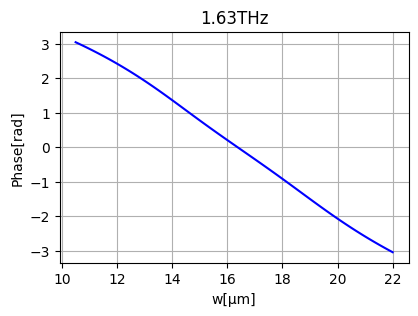

In [32]:
fig, ax1 = plt.subplots(figsize=(4.5, 3)) 

# Plotting phase_shifted on the left y-axis
ax1.plot(width_values, phase_shifted, color='blue', label='Phase')
ax1.set_xlabel('w[µm]')
ax1.set_ylabel('Phase[rad]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Creating a twin axis for average_power
#ax2 = ax1.twinx()
#ax2.plot(width_values, average_power, color='red', label='T')
#ax2.set_ylabel('T', color='red')
#ax2.tick_params(axis='y', labelcolor='red')
#ax2.set_ylim(0, 1)


# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.title('1.63 THz')
plt.show()

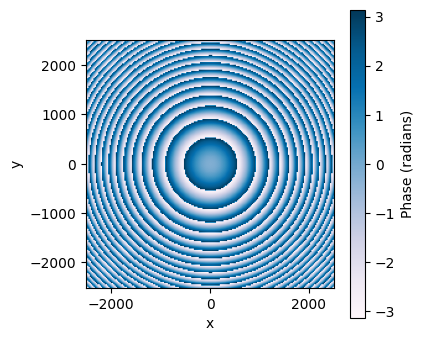

In [51]:
#Phase distribution

wavelength = 184.306/3.3823
z_distance = 5025    # Propagation distance
aperture_radius = 1.0   # Radius of circular aperture


x_range = np.linspace(-2512.5, 2512.5, 201)
y_range = np.linspace(-2512.5, 2512.5, 201)

# Compute the complex amplitude at the observation plane
complex_amplitude = metalens.rayleigh_sommerfeld(x_range[:, np.newaxis], y_range[np.newaxis, :], z_distance, metalens.aperture_function, wavelength, aperture_radius)

# Extract phase and intensity information
pha = np.angle(complex_amplitude)
intensity = np.abs(complex_amplitude)**2

# Plot the phase distribution
plt.figure(figsize=(4, 4))
plt.imshow(pha, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], cmap='PuBu', origin='lower')
plt.colorbar(label='Phase (radians)')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Phase Distribution at Observation Plane')
plt.show()

In [37]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the cyclic colormap

colors = [(0, 'white') , (1.0, 'blue')]

# Create the cyclic colormap
map = LinearSegmentedColormap.from_list('map', colors, N=1024)

In [35]:
n = 201 #number of unit cells in x and y direction

#the phase is shifted such that at the center of the metalens there are the biggest pillars
central_phase = pha[100,100]

pha_shifted = np.angle(complex_amplitude * np.exp(-1j * (np.pi -0.1+ central_phase)))

corresponding_widths = np.zeros((n,n))

#matching between phase distribution and unit cells library
for i in range(n):
    for j in range(n):
        target_phase = pha_shifted[i,j]  

        differences = [abs(phase - target_phase) for phase in phase_shifted]

        min_difference_index = differences.index(min(differences))

        corresponding_widths[i, j] = width_values[min_difference_index]

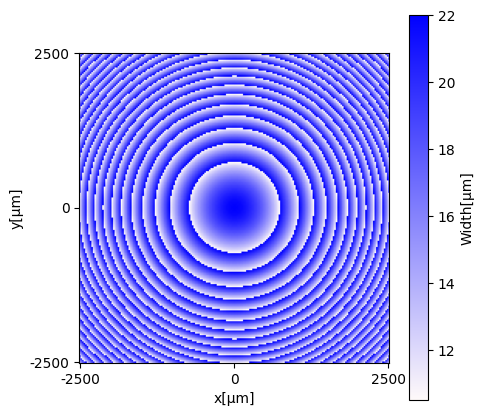

In [32]:
cbar.set_label('Width[µm]', labelpad=10)


plt.figure(figsize=(5, 5))
plt.imshow(corresponding_widths, cmap=map, origin='lower')
plt.colorbar(label='Width[µm]')
plt.xlabel('x[µm]')
plt.ylabel('y[µm]')
plt.xticks(ticks=[0, 100, 200], labels=[-2500, 0, 2500 ])
plt.yticks(ticks=[0, 100, 200], labels=[-2500, 0, 2500 ])
plt.grid(False)
plt.show()

In [ ]:
#np.savetxt("metalens_1p6thz_p25_h100_f5_load20.csv", corresponding_widths, delimiter=',', fmt='%.1f')